# New York City Taxi Fare Prediction

This notebook was inspired from the "Another Machine Learning Walk-Through and a Challenge" by Will Koehrsen.

- https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


## Data Exploration and Data Cleaning

In [2]:
df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 500_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
df = df.dropna()
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


Text(0.5, 1.0, 'Fare Distribution')

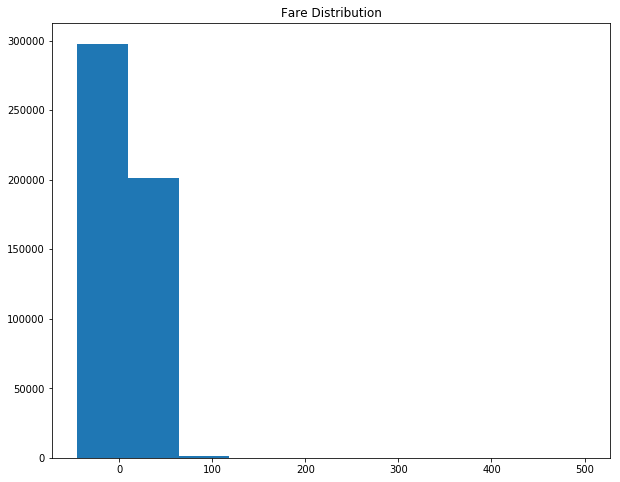

In [4]:
plt.figure(figsize = (10,8))
plt.hist(df['fare_amount'])
plt.title('Fare Distribution')

In [5]:
print(f"Number of negative fares: {len(df[df['fare_amount'] < 0])}")
print(f"Number of fares equal to 0: {len(df[df['fare_amount'] == 0])}")

Number of negative fares: 21
Number of fares equal to 0: 14


In [6]:
df = df[df['fare_amount'].between(left = 2.5, right= df['fare_amount'].max())]

### Empirical Comulative Distribution Function

The Empirical Comulative Distribution Function (ECDF) can be used to show distributions of a single variable. ECDF shows the variable on the X axis and the Percentile on the Y axis.

In [7]:
def ecdf(x):
    x = np.sort(x)
    n = len(x)
    # Going from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    return x, y

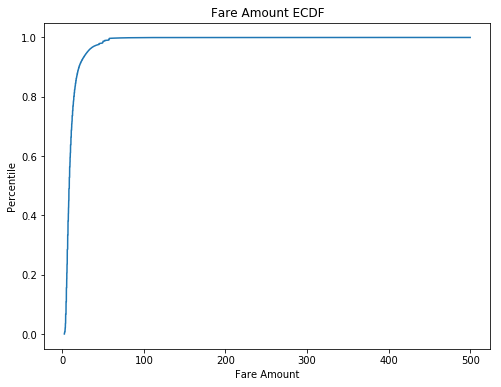

In [8]:
x, y = ecdf(df['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(x, y)
plt.ylabel('Percentile'); 
plt.xlabel('Fare Amount');
plt.title('Fare Amount ECDF'); 

In [9]:
df = df[df['fare_amount'].between(left = 2.5, right= 70)]

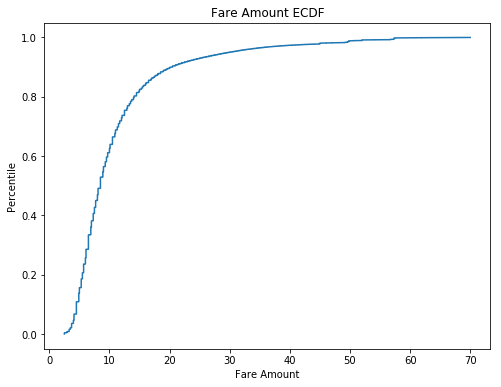

In [10]:
x, y = ecdf(df['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(x, y)
plt.ylabel('Percentile'); 
plt.xlabel('Fare Amount');
plt.title('Fare Amount ECDF'); 

Text(0, 0.5, 'Frequency')

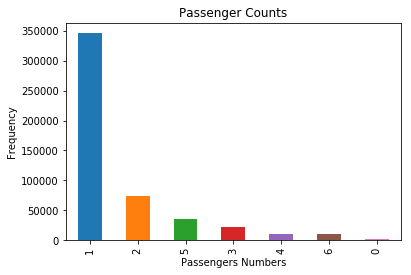

In [11]:
df['passenger_count'].value_counts().plot.bar();
plt.title('Passenger Counts')
plt.xlabel('Passengers Numbers') 
plt.ylabel('Frequency')

In [12]:
df = df.loc[df['passenger_count'] < 6]

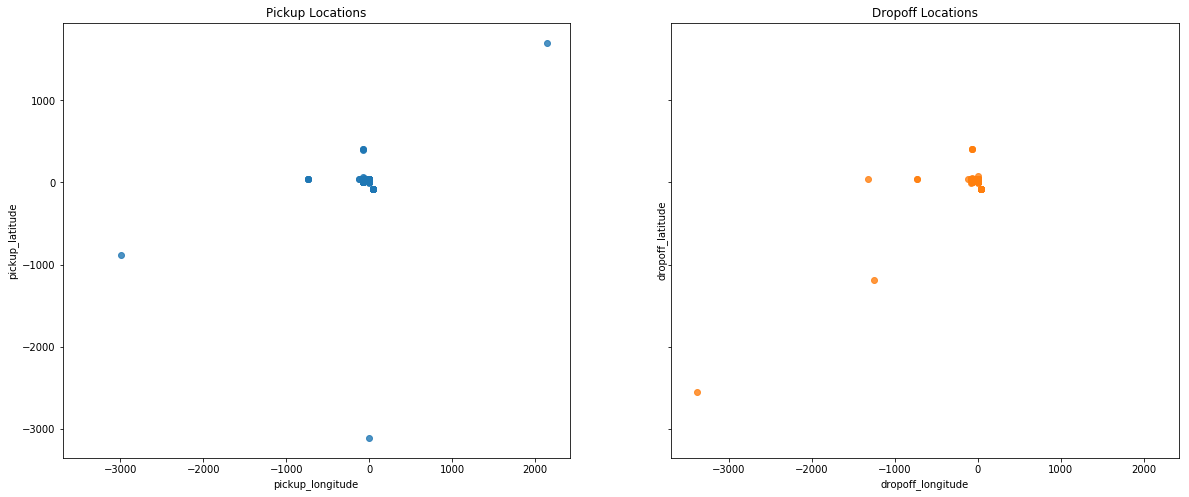

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = df, ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = df, ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

## Feature Engineering

In [14]:
# Absolute difference in latitude and longitude
df['abs_lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
df['abs_lon_diff'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()

Text(0.5, 1.0, 'Absolute latitude difference vs Absolute longitude difference')

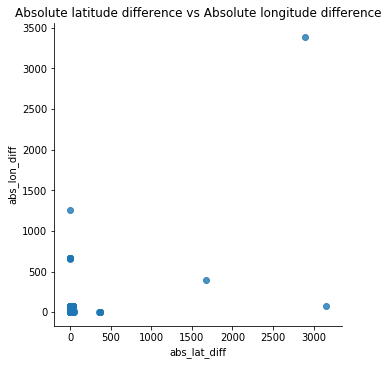

In [15]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False, data = df)
plt.title('Absolute latitude difference vs Absolute longitude difference')

In [16]:
zero_diff = df[(df['abs_lat_diff'] == 0) & (df['abs_lon_diff'] == 0)]
zero_diff.shape

(13922, 9)

In [17]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [18]:
df['euclidean'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 2)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(0, 500)

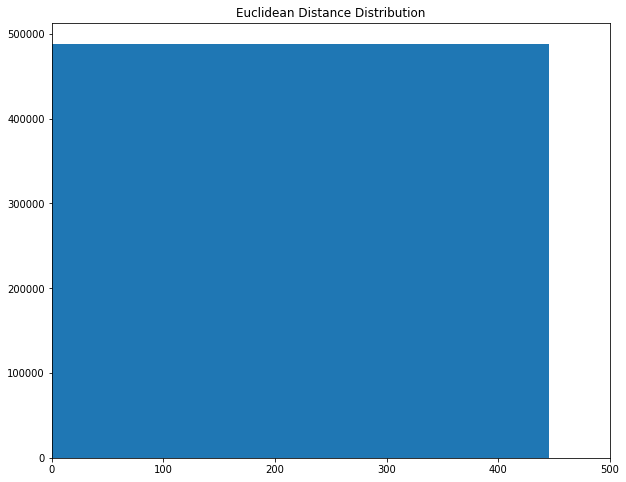

In [19]:
plt.figure(figsize = (10,8))
plt.hist(df['euclidean'])
plt.title('Euclidean Distance Distribution')
ax = plt.subplot(111)
ax.set_xlim([0, 500])

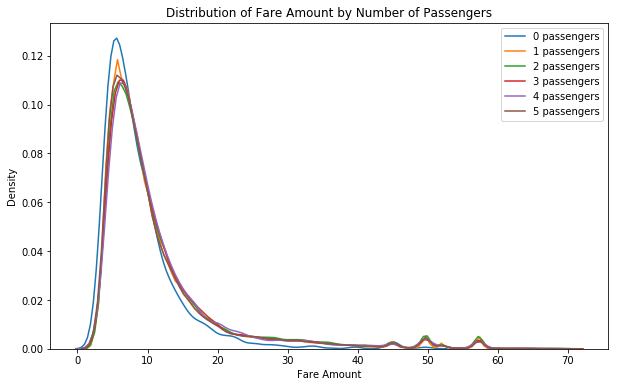

In [20]:
plt.figure(figsize = (10, 6))

for p, grouped in df.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = f'{p} passengers');
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

In [21]:
df.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
0,8.919777,1790
1,11.083368,345414
2,11.688427,73763
3,11.392164,21733
4,11.591508,10589
5,11.133058,35283


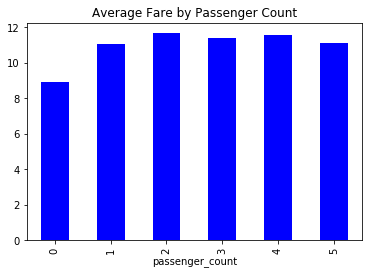

In [22]:
df.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');

### Haversine distance

In [23]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [24]:
df['haversine'] =  haversine_np(df['pickup_longitude'], df['pickup_latitude'],
                         df['dropoff_longitude'], df['dropoff_latitude']) 

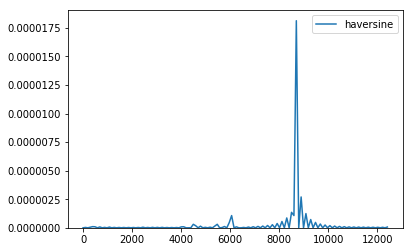

In [25]:
sns.kdeplot(df['haversine']);

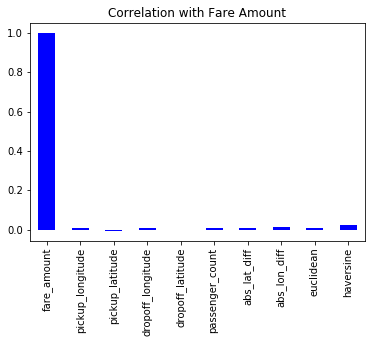

In [26]:
corrs = df.corr()
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');

### Adding Featured Engineered Features to Test Data

In [27]:
test = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv', 
                   parse_dates = ['pickup_datetime'])

# Create absolute differences
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,euclidean,haversine
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,0.022133,0.023348,0.035146,3.439145
std,0.042774,0.033541,0.039072,0.035435,1.278747,0.025589,0.036719,0.042459,3.976739
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,0.007279,0.006354,0.013261,1.299703
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,0.014715,0.013123,0.022423,2.219848
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,0.028261,0.024557,0.040170,4.049746
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,0.633213,0.849168,1.057330,100.105909


In [28]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(df, np.array(df['fare_amount']), 
                                                      test_size = 0.30)

In [29]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[21:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [30]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [31]:
evaluate(xgbr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.12 	 mape = 23.12
Validation: rmse = 4.18 	 mape = 23.07


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

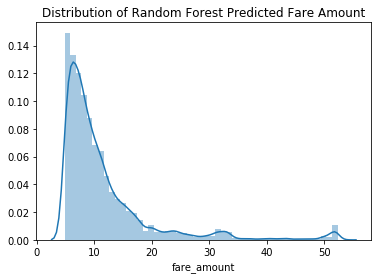

In [32]:
preds = xgbr.predict(test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predicted Fare Amount');